In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely

from matplotlib.patches import Rectangle, Patch
from global_land_mask import globe

import xarray as xr


In [2]:
places = pd.read_csv('../data/place_df.csv')

(10368, 8)
(10368, 16)


,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,LAT_5,LON_5,Attribution_Category_2016,Attribution_Category_2010,precip_da_cat_original,temp_da_cat_original,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,is_land
0,-88.75,-178.75,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False
1,-88.75,-176.25,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False
2,-88.75,-173.75,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False
3,-88.75,-171.25,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False
4,-88.75,-168.75,0.0,0.0,0.0,0.0,-87.5,-167.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False


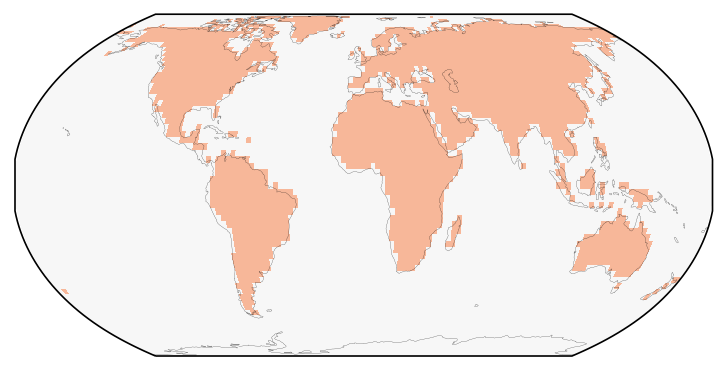

In [3]:
pdf = pd.read_csv(f'../data/gridcell_studies_6 - Precipitation - upper_pred_2.5.csv').rename(columns={
    "da_cat": "precip_da_cat",
    "n_study_prop": "precip_study_prop"
})
tdf = pd.read_csv(f'../data/gridcell_studies_6 - Temperature - upper_pred_2.5.csv').rename(columns={
    "da_cat": "temp_da_cat",
    "n_study_prop": "temp_study_prop"
})
print(tdf.shape)

df = (pdf[["LAT","LON","precip_da_cat","precip_study_prop"]]
      .merge(tdf[["LAT","LON","temp_da_cat","temp_study_prop"]])
     )#.fillna(0)

df.loc[df['LON']>180,"LON"]-=360

df['LAT_5'] = df['LAT']//5*5+5*0.5
df['LON_5'] = df['LON']//5*5+5*0.5



new_temp = (
    xr
    .open_dataset('../data/d_a/tas_attribution_categories_g05_centred.nc', decode_times=False)
)
new_temp = new_temp.to_dataframe().reset_index()

df = df.merge(new_temp.rename(columns={"latitude":"LAT_5", "longitude": "LON_5"}), how="left")

temp_variable = 'temp_da_cat'
temp_variable = 'Attribution_Category_2016'

df['precip_da_cat_original'] = df['precip_da_cat']
df['temp_da_cat_original'] = df[temp_variable]

df['precip_da_cat'] = abs(df['precip_da_cat']).fillna(0)
df['temp_da_cat'] = abs(df[temp_variable]).fillna(0)

df['temp_da_binary'] = np.where(df['temp_da_cat']>1,1,0)
df['precip_da_binary'] = np.where(df['precip_da_cat']>1,1,0)

df["n_da_impacts"] = df[['temp_da_binary','precip_da_binary']].sum(axis=1)

df["max_da_cat"] = np.max(df[['precip_da_cat','temp_da_cat']],axis=1)
print(df.shape)



df['is_land'] = globe.is_land(df.LAT, df.LON)
df.loc[df['LAT']<-60,'is_land'] = False

# Plot land

fig = plt.figure(dpi=150)

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

n = np.array(df.is_land).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
zm = np.ma.masked_less(n, 2)

ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)



df.head()



## max_da_cat is the largest absolute d&a category across precip and temp. These are the places where we know something is going on

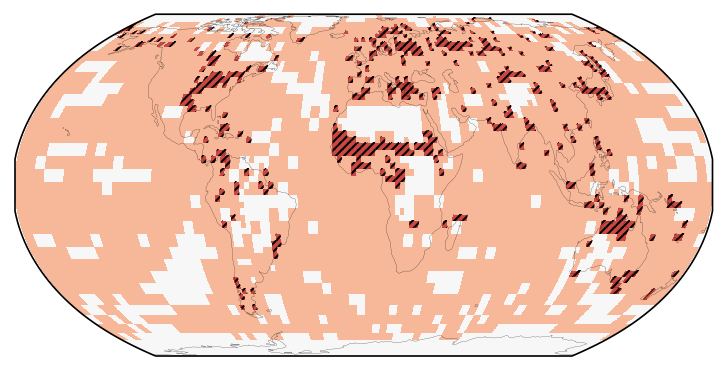

In [4]:
fig = plt.figure(dpi=150)

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)



n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
zm = np.ma.masked_less(n, 2)

ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

In [5]:
df.loc[
    (df['precip_da_cat']>1) &
    (df['temp_da_cat']>1),
    "study_addition"
] = "add" 

df.loc[
    (df['precip_da_cat']<=1) &
    (df['temp_da_cat']<=1),
    "study_addition"
] = "add" 

df.loc[
    (df['precip_da_cat']>1) &
    (df['temp_da_cat']<=1),
    "study_addition" 
] = "precip" 

df.loc[
    (df['precip_da_cat']<=1) &
    (df['temp_da_cat']>1),
    "study_addition"  
] = "temp"

df.loc[df['study_addition']=="temp","total_study_prop"] = df.loc[df['study_addition']=="temp","temp_study_prop"]
df.loc[df['study_addition']=="precip","total_study_prop"] = df.loc[df['study_addition']=="precip","temp_study_prop"]
df.loc[df['study_addition']=="add","total_study_prop"] = df.loc[df['study_addition']=="add",["precip_study_prop","temp_study_prop"]].sum(axis=1)

df.head()

,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,LAT_5,LON_5,Attribution_Category_2016,Attribution_Category_2010,precip_da_cat_original,temp_da_cat_original,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,is_land,study_addition,total_study_prop
0,-88.75,-178.75,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False,add,0.0
1,-88.75,-176.25,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False,add,0.0
2,-88.75,-173.75,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False,add,0.0
3,-88.75,-171.25,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False,add,0.0
4,-88.75,-168.75,0.0,0.0,0.0,0.0,-87.5,-167.5,NaN,NaN,NaN,NaN,0,0,0,0.0,False,add,0.0


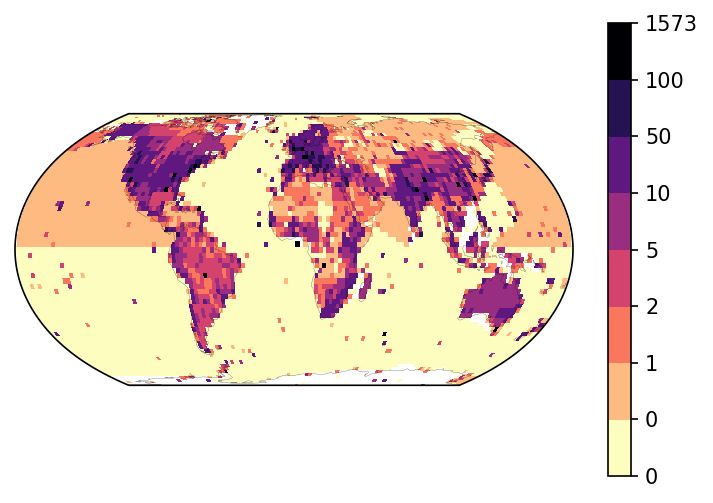

In [6]:
fig = plt.figure(dpi=150)

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

n = np.array(df.total_study_prop).reshape(len(df.LAT.unique()),len(df.LON.unique()))
#vm = round(n.max()/10*10)
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,0.5,1,2.5,5,10,50,100,vm])


mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
   #norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    transform=ccrs.PlateCarree(),
    #alpha=0.5
)
cbar = plt.colorbar(mesh)

# Distribution of number studies on land

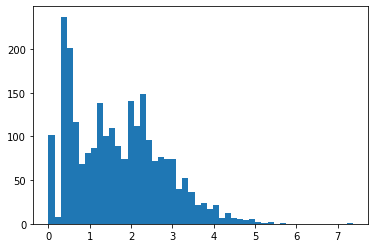

In [7]:
plt.hist(np.log(df[df['is_land']==True].total_study_prop+1),bins=50)
plt.show()

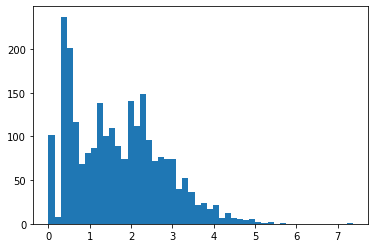

In [8]:
plt.hist(np.log(df[df['is_land']==True].total_study_prop+1),bins=50)
plt.show()

median 3.9767310226770562
mean 10.14523251630676
q2 0.9676684263294836


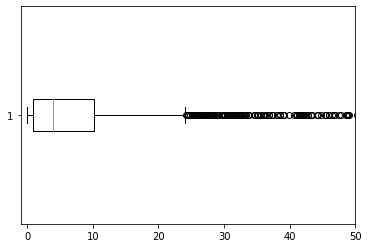

In [9]:
fig, ax = plt.subplots()
ax.boxplot(df[df['is_land']==True].total_study_prop, vert=False)
ax.set_xlim(xmax=50, xmin=-1)
print("median", df[df['is_land']==True].total_study_prop.median())
print("mean", df[df['is_land']==True].total_study_prop.mean())
print("q2", df[df['is_land']==True].total_study_prop.quantile(.25))

In [10]:
print("q3", df[df['is_land']==True].total_study_prop.quantile(np.linspace(0,1,5)))

q3 0.00       0.000000
0.25       0.967668
0.50       3.976731
0.75      10.241229
1.00    1573.239634
Name: total_study_prop, dtype: float64


In [11]:
print("q3", df[df['is_land']==True].total_study_prop.quantile(np.linspace(0,1,11)))

q3 0.0       0.000000
0.1       0.517668
0.2       0.766039
0.3       1.454211
0.4       2.491212
0.5       3.976731
0.6       6.378663
0.7       8.479671
0.8      12.751528
0.9      21.706263
1.0    1573.239634
Name: total_study_prop, dtype: float64


In [12]:
lots = 5
little = 1

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']<little),"evidence_cat"
] = 1

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']>=little),"evidence_cat"
] = 2

df.loc[
    (abs(df['max_da_cat'])>1) & (df['total_study_prop']>=lots),"evidence_cat"
] = 3

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']<little),"evidence_cat"
] = 4

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']>=little),"evidence_cat"
] = 5

df.loc[
    (abs(df['max_da_cat'])<=1) & (df['total_study_prop']>=lots),"evidence_cat"
] = 6

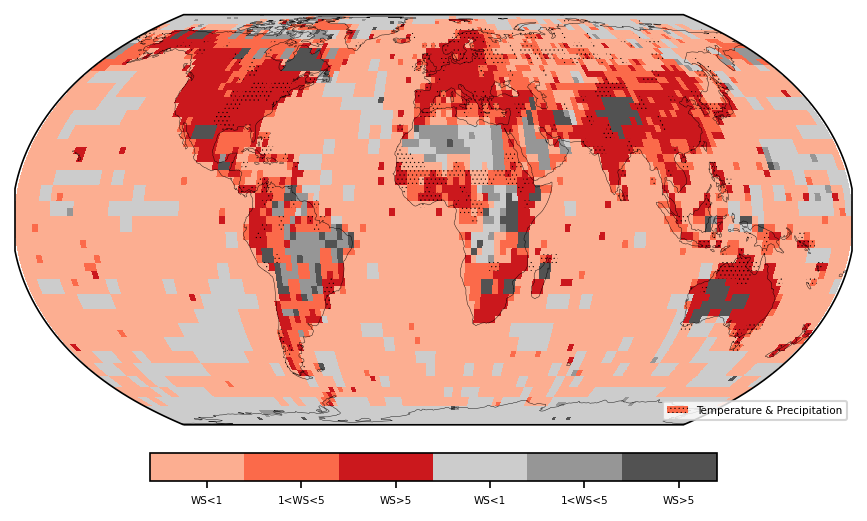

In [13]:
fig = plt.figure(figsize=(7.2, 5), dpi=150)

mpl.rcParams['hatch.linewidth'] = 0.2

ax = plt.subplot(projection=ccrs.EqualEarth())


n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))

ax.coastlines(lw=0.2)

pubugn = ['#ece2f0','#a6bddb','#1c9099']
pubugn = ['#f6eff7','#bdc9e1','#67a9cf','#02818a'][1:]
greens = ['#f7fcb9','#addd8e','#31a354']

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]

reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.05, fraction=0.05)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    #hatch="//////",
    hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

cbar.set_ticklabels([
    "D&A trend\n 0 impacts",
    f"D&A trend\n <{lots} impacts",
    f"D&A trend\n >{lots} impacts",
    "no D&A trend\n 0 impacts",
    f"no D&A trend\n <{lots} impacts",
    f"no D&A trend\n >{lots} impacts",
])

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="......",
    label="Temperature & Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=5, loc="lower right")

cbar.ax.tick_params(labelsize=5)



In [14]:
import math
def area_cell(lat, lon, degrees): 
    # calculate the area of a gridcell given the center lat and lon and the size in degrees
    if lon <0:
        lon+=360
    R = 6371
    f0 = math.radians(lat-degrees*0.5)
    f1 = math.radians(lat+degrees*0.5)
    l0 = math.radians(lon-degrees*0.5)
    l1 = math.radians(lon+degrees*0.5)

    return (math.sin(f1)-math.sin(f0)) * (l1 - l0) * R**2

area_cell(89.5,-90,1)

107.89623558970708

In [15]:
df['area'] = df.apply(lambda x: area_cell(x['LAT'], x['LON'], 2.5), axis=1)
df.head()

,LAT,LON,precip_da_cat,precip_study_prop,temp_da_cat,temp_study_prop,LAT_5,LON_5,Attribution_Category_2016,Attribution_Category_2010,...,temp_da_cat_original,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,is_land,study_addition,total_study_prop,evidence_cat,area
0,-88.75,-178.75,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,...,NaN,0,0,0,0.0,False,add,0.0,4.0,1685.654015
1,-88.75,-176.25,0.0,0.0,0.0,0.0,-87.5,-177.5,NaN,NaN,...,NaN,0,0,0,0.0,False,add,0.0,4.0,1685.654015
2,-88.75,-173.75,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,...,NaN,0,0,0,0.0,False,add,0.0,4.0,1685.654015
3,-88.75,-171.25,0.0,0.0,0.0,0.0,-87.5,-172.5,NaN,NaN,...,NaN,0,0,0,0.0,False,add,0.0,4.0,1685.654015
4,-88.75,-168.75,0.0,0.0,0.0,0.0,-87.5,-167.5,NaN,NaN,...,NaN,0,0,0,0.0,False,add,0.0,4.0,1685.654015


In [16]:
area_sums = df[df['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
area_sums

,evidence_cat,n_da_impacts,area,prop
0,1.0,1,1.511810e+07,0.112163
1,1.0,2,2.651988e+06,0.019675
2,2.0,1,2.480335e+07,0.184018
3,2.0,2,5.076529e+06,0.037663
4,3.0,1,4.412842e+07,0.327393
5,3.0,2,1.134517e+07,0.084171
6,4.0,0,8.206037e+06,0.060881
7,5.0,0,1.156219e+07,0.085781
8,6.0,0,1.189558e+07,0.088254


In [17]:
area_sums[area_sums['evidence_cat'].isin([2,3])].prop.sum()

0.633245378539226

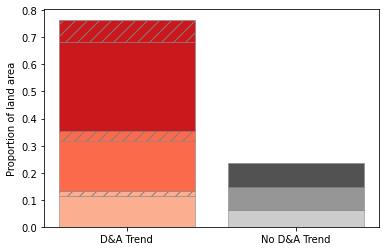

In [18]:
fig, ax = plt.subplots()
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","//"]

mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4

    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        ax.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
ax.set_xticks([0,1])
ax.set_xticklabels(["D&A Trend", "No D&A Trend"])

ax.set_ylabel("Proportion of land area")
    
plt.show()


Text(0.77, 0, 'no D&A\ntrend')

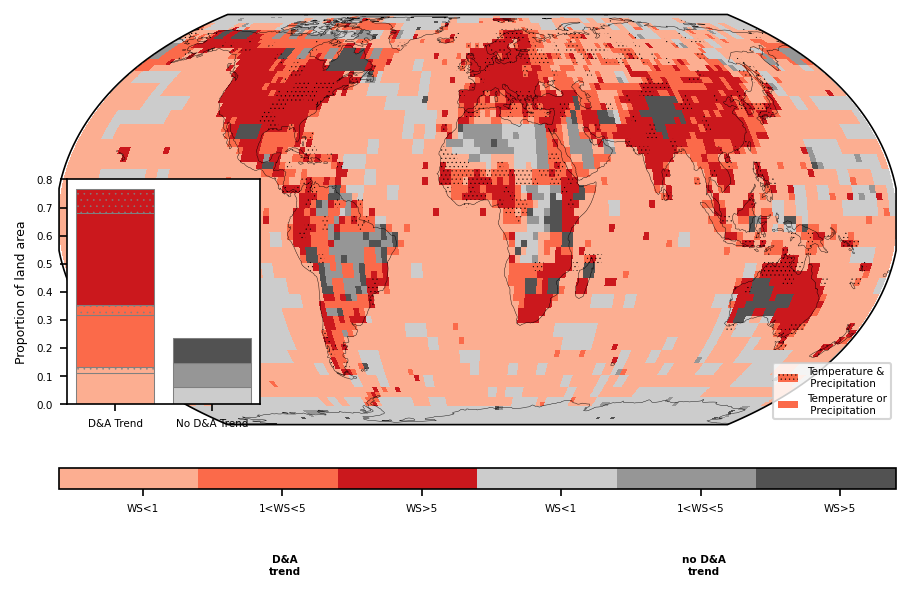

In [19]:
fig = plt.figure(figsize=(7.2, 5), dpi=150)

mpl.rcParams['hatch.linewidth'] = 0.2

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0.08)

ax = plt.subplot(gs[0, 0], projection=ccrs.EqualEarth())
cax = plt.subplot(gs[1, 0])


n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))

ax.coastlines(lw=0.2)

pubugn = ['#ece2f0','#a6bddb','#1c9099']
pubugn = ['#f6eff7','#bdc9e1','#67a9cf','#02818a'][1:]
greens = ['#f7fcb9','#addd8e','#31a354']

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]

reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh, orientation="horizontal", pad=-0.95, fraction=1,ax=cax, aspect=40)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cax.axis('off')

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    #hatch="//////",
    hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

cbar.set_ticklabels([
    "D&A trend\n 0 impacts",
    f"D&A trend\n <{lots} impacts",
    f"D&A trend\n >{lots} impacts",
    "no D&A trend\n 0 impacts",
    f"no D&A trend\n <{lots} impacts",
    f"no D&A trend\n >{lots} impacts",
])

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="......",
    label="Temperature &\n Precipitation",
)

ax.add_patch(rect)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    label="Temperature or\n Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=5, loc="lower right")

cbar.ax.tick_params(labelsize=5)

###
axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","...."]

#mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4
    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        axins.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D&A Trend", "No D&A Trend"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)

cax.text(0.27,0, "D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.77,0, "no D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")
#ax.text(1.6,0.8, "no D&A\ndata", fontsize=5,ha="left", va="center", fontweight="bold")


Text(0, 0.5, 'Proportion of land area')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/IPython/core/events.py:73: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


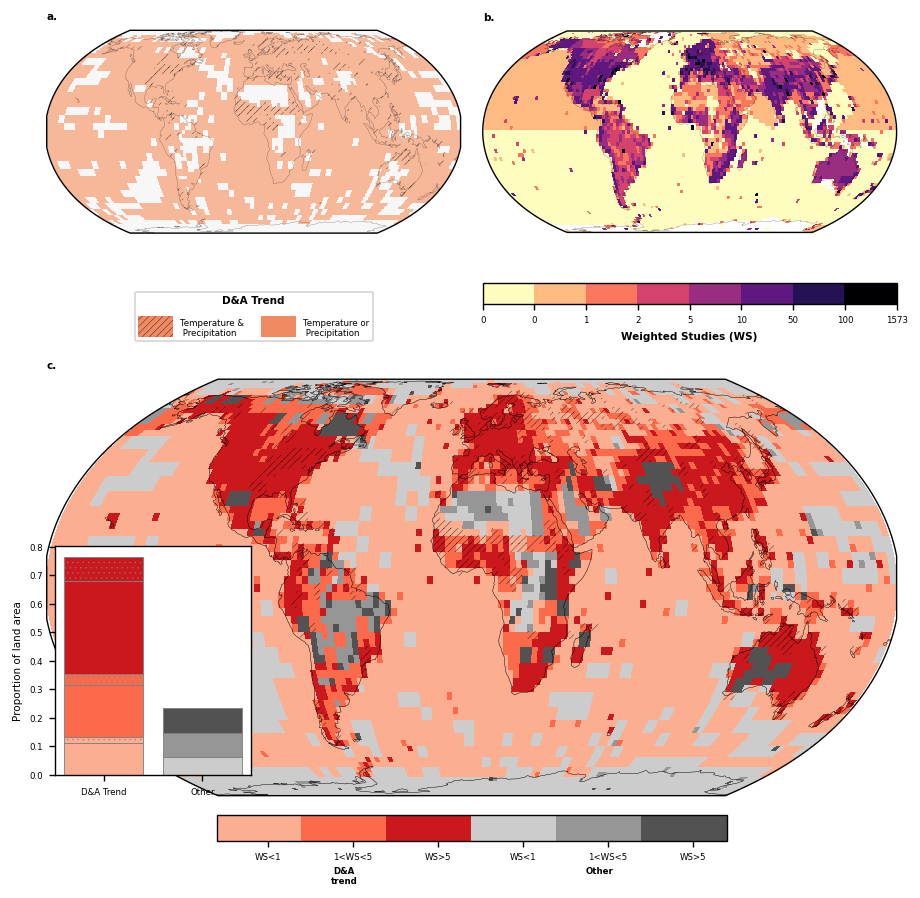

In [20]:
fig = plt.figure(figsize=(7.2,7.2), dpi=125, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=[1, 0.1,1.5, 0.1])


#######################################################
## 

ax = plt.subplot(gs[0,0], projection=ccrs.EqualEarth())
ax.set_title("a.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)
n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))
n[n==2]=1
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))
zm = np.ma.masked_less(n, 2)
ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)



cax = plt.subplot(gs[1,0])

patch_1 = Patch(label='Temperature &\n Precipitation', facecolor="#ef8a62", hatch="//////")
patch_2 = Patch(label='Temperature or\n Precipitation', facecolor="#ef8a62",)

leg = cax.legend(
    handles = [patch_1, patch_2], 
    fontsize=5, ncol=2, handlelength=4, labelspacing=1.5,
    loc="upper center", bbox_to_anchor=(0.5,1.1)
    #prop={"size":8}
)

leg.set_title('D&A Trend',prop={'size':6, 'weight': "bold"})

for patch in leg.get_patches():
    patch.set_height(12)
    patch.set_y(-3)

cax.axis('off')

########################################################
## Study distribution
ax = plt.subplot(gs[0,1], projection=ccrs.EqualEarth())
ax.set_title("b.", fontsize=6, fontweight="bold", loc="left" )

ax.coastlines(lw=0.1)

n = np.array(df.total_study_prop).reshape(len(df.LAT.unique()),len(df.LON.unique()))
vm = n.max()
n[n==0] = np.nan

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    #norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    transform=ccrs.PlateCarree(),
    #alpha=0.5
)
cax = plt.subplot(gs[1,1])
cbar = plt.colorbar(mesh, orientation="horizontal", ax=cax, pad=-1)
cbar.ax.tick_params(labelsize=5)
cbar.ax.set_xlabel("Weighted Studies (WS)", fontsize=6, fontweight="bold")

cax.axis('off')

#################################################################
#################################################################
## Summary plot

ax = plt.subplot(gs[2,0:], projection=ccrs.EqualEarth())
ax.set_title("c.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

mpl.rcParams['hatch.linewidth'] = 0.2

n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))

ax.coastlines(lw=0.2)

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[3,:])
cax.axis('off')

cbar = plt.colorbar(mesh, orientation="horizontal", pad=-1.3, fraction=0.25,ax=cax, shrink=0.6)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)


cax.text(0.35,-0.8, "D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.65,-0.8, "Other", fontsize=5,ha="center", va="top", fontweight="bold")
cbar.ax.tick_params(labelsize=5)

## Dotted part

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","...."]

#mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4
    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        axins.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D&A Trend", "Other"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)





Text(0, 0.5, 'Proportion of land area')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/IPython/core/events.py:73: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


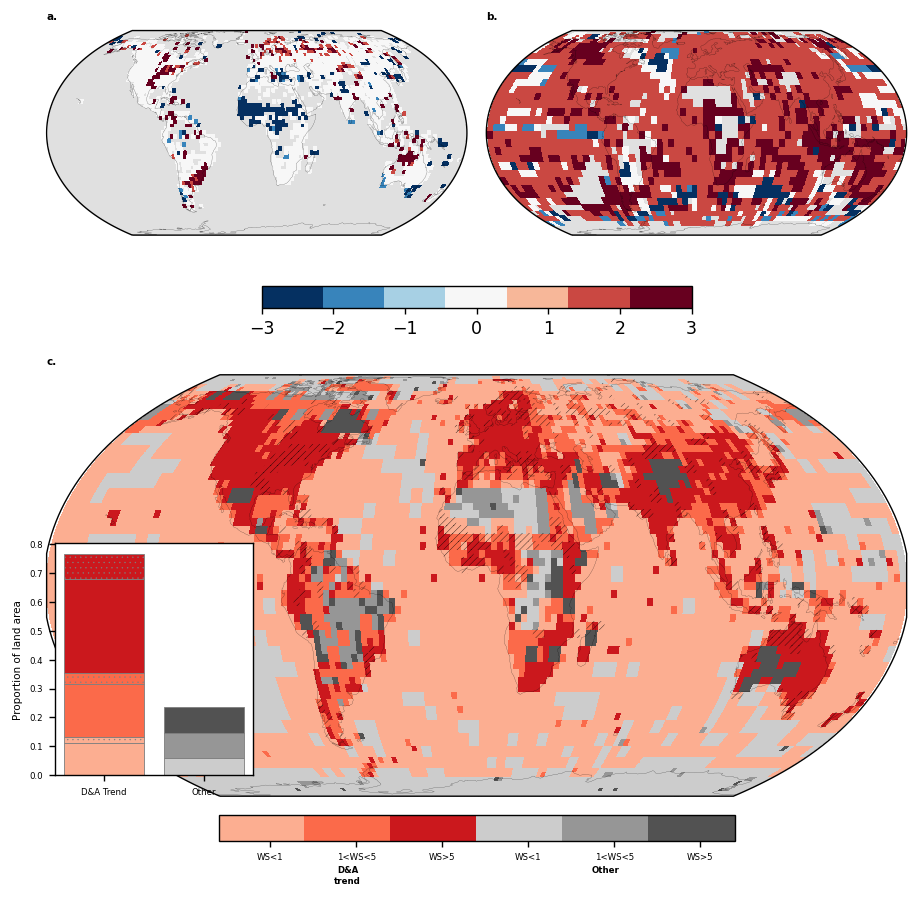

In [21]:
fig = plt.figure(figsize=(7.2,7.2), dpi=125, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=[1, 0.05, 1.5, 0.1])


#######################################################
## 

ax = plt.subplot(gs[0,0], projection=ccrs.EqualEarth())
ax.set_title("a.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.precip_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[1,:])
cax.axis('off')
cbar = plt.colorbar(
    mesh, orientation="horizontal", pad=-0.95, fraction=0.05, ax=cax,
    shrink=0.5
)


########################################################
## Study distribution
ax = plt.subplot(gs[0,1], projection=ccrs.EqualEarth())
ax.set_title("b.", fontsize=6, fontweight="bold", loc="left" )

ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.temp_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

#################################################################
#################################################################
## Summary plot

ax = plt.subplot(gs[2,0:], projection=ccrs.EqualEarth())
ax.set_title("c.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

mpl.rcParams['hatch.linewidth'] = 0.2

n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))



greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[3,:])
cax.axis('off')

cbar = plt.colorbar(mesh, orientation="horizontal", pad=-1.3, fraction=0.25,ax=cax, shrink=0.6)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)


cax.text(0.35,-0.8, "D&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.65,-0.8, "Other", fontsize=5,ha="center", va="top", fontweight="bold")
cbar.ax.tick_params(labelsize=5)

## Dotted part

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","...."]

#mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4
    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        axins.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D&A Trend", "Other"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)





Text(0, 0.5, 'Proportion of land area')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/IPython/core/events.py:73: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


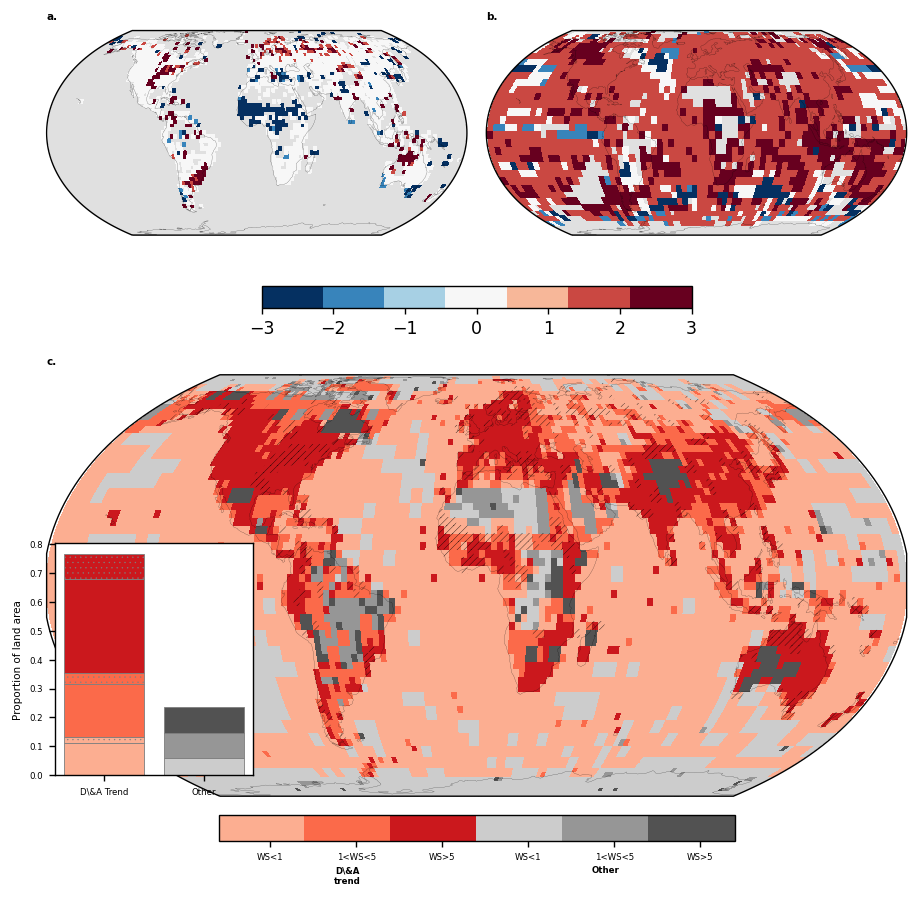

In [22]:
fig = plt.figure(figsize=(7.2,7.2), dpi=125, constrained_layout=True)
gs = fig.add_gridspec(4, 2, height_ratios=[1, 0.05, 1.5, 0.1])


#######################################################
## 

ax = plt.subplot(gs[0,0], projection=ccrs.EqualEarth())
ax.set_title("a.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.precip_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[1,:])
cax.axis('off')
cbar = plt.colorbar(
    mesh, orientation="horizontal", pad=-0.95, fraction=0.05, ax=cax,
    shrink=0.5
)


########################################################
## Study distribution
ax = plt.subplot(gs[0,1], projection=ccrs.EqualEarth())
ax.set_title("b.", fontsize=6, fontweight="bold", loc="left" )

ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.temp_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

#################################################################
#################################################################
## Summary plot

ax = plt.subplot(gs[2,0:], projection=ccrs.EqualEarth())
ax.set_title("c.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

mpl.rcParams['hatch.linewidth'] = 0.2

n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))



greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[3,:])
cax.axis('off')

cbar = plt.colorbar(mesh, orientation="horizontal", pad=-1.3, fraction=0.25,ax=cax, shrink=0.6)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cbar.set_ticklabels([
    f"WS<{little}",
    f"{little}<WS<{lots}",
    f"WS>{lots}"
]*2)


cax.text(0.35,-0.8, "D\&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.65,-0.8, "Other", fontsize=5,ha="center", va="top", fontweight="bold")
cbar.ax.tick_params(labelsize=5)

## Dotted part

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

dots = ax.pcolor(
    df.LON.unique(),
    df.LAT.unique(),
    zm,
    hatch="//////",
    #hatch="......",
    transform=ccrs.PlateCarree(),
    alpha=0.
)

axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","...."]

#mpl.rcParams['hatch.linewidth'] = 1

for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
    x = name//4
    for j, group in group.groupby('n_da_impacts'):
        y = group['prop'].values[0]
        axins.bar(
            x,y, bottom=bottoms[x], 
            color=colors[i], hatch=hatch_types[j],
            edgecolor="grey",
            linewidth=0.5
        )
        bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)





,ndf_id,doc_id
0,7574.0,486888.0
1,8660.0,230251.0
2,8661.0,230251.0
3,8666.0,230251.0
4,8667.0,230251.0
...,...,...
1694001,7152.0,3986777.0
1694002,7152.0,3986777.0
1694003,6866.0,3986777.0
1694004,6866.0,3986777.0


In [56]:
places = pd.read_csv('../data/place_df.csv')

import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent

degrees = 2.5
t_studies_df = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
t_studies_df["da_var"] = "Temperature"
if temp_variable=='Attribution_Category_2016':
    t_studies_df = t_studies_df.drop(columns=["da_trend_cells","da_data_cells"]).rename(columns={
        "new_da_trend_cells": "da_trend_cells",
        "new_da_data_cells": "da_data_cells"
    })
p_studies_df = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
p_studies_df["da_var"] = "Precipitation"

df_studies = pd.concat([t_studies_df,p_studies_df])

df_studies = df_studies[pd.notna(df_studies["gridcells"]) & df_studies["gridcells"]>0]

df_studies["da_trend_p"] = df_studies["da_trend_cells"] / df_studies["gridcells"]

df_studies.shape

(37899, 234)

In [57]:
df_studies[(df_studies['da_var']=="Temperature") & (df_studies['da_trend_p']>1)]

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,2 - 2.5. Detection of a regional climate trend (no attribution) - std_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,df_da,gridcells,feature_type,da_trend_cells,da_data_cells,da_var,da_trend_p


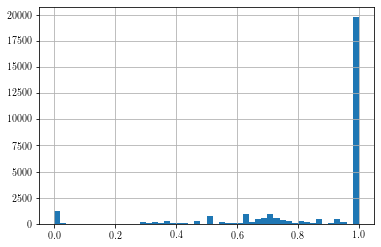

In [58]:
df_studies[df_studies['da_var']=="Temperature"].da_trend_p.hist(bins=50)

In [59]:
# Merge actual and predicted categories
pred_cats = [c for c  in df_studies.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df_studies[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df_studies.loc[df_studies[label]==1,cs] = 1
    print(df_studies[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction",
    "12 - Total"
]

4299.3941876741
4332.3941876741
5368.001105287318
5383.001105287318
3285.6511919414793
3339.673251435902
8248.421056475916
8309.421056475916
12781.964560849228
12839.964560849228
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']


In [60]:
continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

In [61]:
sector_cols = [x for x in df_studies.columns if "12 - " in x and "mean" in x]
sector_cols

['12 - Coastal and marine Ecosystems - mean_prediction',
 '12 - Human and managed - mean_prediction',
 '12 - Mountains, snow and ice - mean_prediction',
 '12 - Rivers, lakes, and soil moisture - mean_prediction',
 '12 - Terrestrial ES - mean_prediction']

South America
North America
Africa
Europe
Asia
Oceania


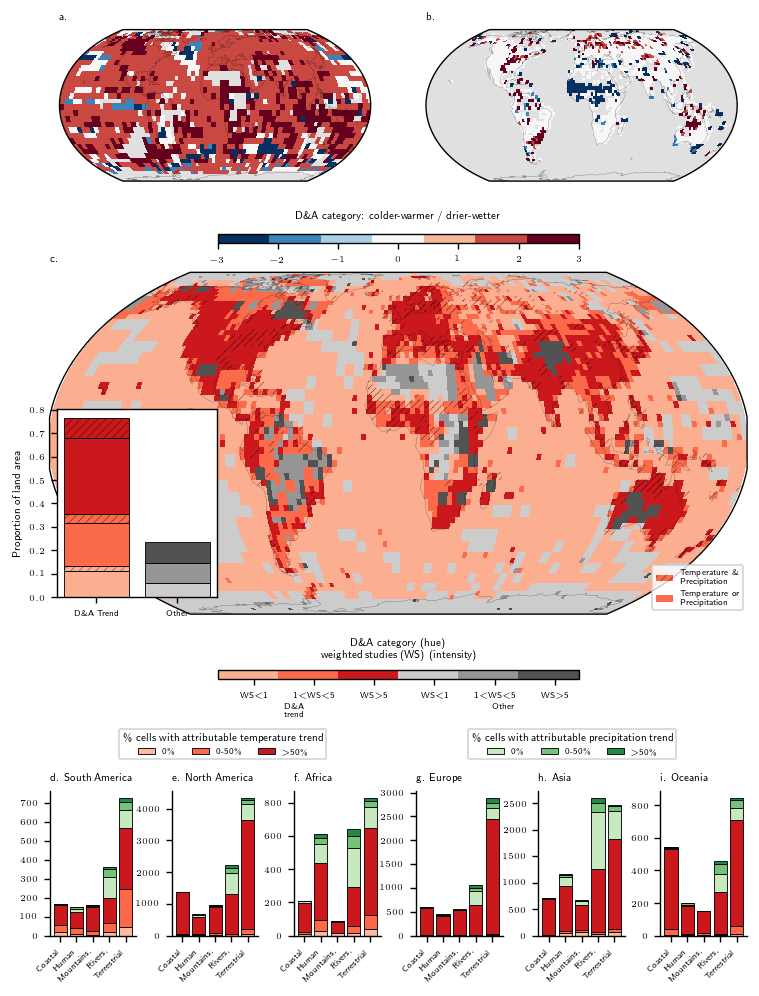

In [62]:
from matplotlib.patches import ConnectionPatch, ConnectionStyle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

sector_cols = [x for x in df_studies.columns if "12 - " in x and "mean" in x]


fig = plt.figure(figsize=(7.2,9.6), dpi=125)
gs = fig.add_gridspec(6, 6, height_ratios=[.63, 0.15, 1.45, 0.15,0.25,0.6],figure=fig, wspace=0.41)


#######################################################
## 

ax = plt.subplot(gs[0,3:], projection=ccrs.EqualEarth())
ax.set_title("b.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.precip_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

## Colorbar
cax = plt.subplot(gs[1,:])

cax.axis('off')
cbar = plt.colorbar(
    mesh, orientation="horizontal", ax=cax, pad=-0.5,
    aspect=40, 
    fraction=0.25
)
cbar.set_label('D\&A category: colder-warmer / drier-wetter', fontsize=6, labelpad=-30)

cbar.ax.tick_params(labelsize=5)
#cax.set_position(pos2)

########################################################
## Study distribution
ax = plt.subplot(gs[0,:3], projection=ccrs.EqualEarth())
ax.set_title("a.", fontsize=6, fontweight="bold", loc="left" )

ax.coastlines(lw=0.1)

bn = np.zeros((len(df.LAT.unique()), len(df.LON.unique())))
bn+=1

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    bn,
    cmap = mpl.colors.ListedColormap(["#e0e0e0"]),
    transform=ccrs.PlateCarree(),
)

n = np.array(df.temp_da_cat_original).reshape(len(df.LAT.unique()),len(df.LON.unique()))
mesh = ax.pcolormesh(
    df.LON.unique(),
    df.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('RdBu_r',7), vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
)

#################################################################
#################################################################
## Summary plot

ax = plt.subplot(gs[2,0:], projection=ccrs.EqualEarth())
ax.set_title("c.", fontsize=6, fontweight="bold", loc="left" )
ax.coastlines(lw=0.1)



n = np.array(df.evidence_cat).reshape(len(df.LAT.unique()),len(df.LON.unique()))



greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]

colors = reds + greys #pubugn

cmap = mpl.colors.ListedColormap(colors)

mesh = ax.pcolormesh(
    df.LON.unique(),#-degrees*0.5,
    df.LAT.unique(),#-degrees*0.5,
    n,
    cmap = cmap,
    transform=ccrs.PlateCarree(),
)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="/////",
    label="Temperature \&\n Precipitation",
)

ax.add_patch(rect)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    label="Temperature or\n Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=5, loc="lower right")

## Colorbar
cax = plt.subplot(gs[3,:])
#cax.axis('off')

cbar = plt.colorbar(
    mesh, orientation="horizontal", ax=cax, pad=-0.5,
    aspect=40, 
    fraction=0.25
)
cbar.set_ticks(np.array(np.linspace(1,cmap.N,cmap.N+1)[:-1]+0.5))

cbar.set_ticklabels([
    fr"WS\textless{little}",
    fr"{little}\textless WS\textless{lots}",
    fr"WS\textgreater{lots}"
]*2)


cax.text(0.35,-0.3, "D\&A\ntrend", fontsize=5,ha="center", va="top", fontweight="bold")        
cax.text(0.65,-0.3, "Other", fontsize=5,ha="center", va="top", fontweight="bold")
cbar.set_label('D\&A category (hue)\nweighted studies (WS) (intensity)', fontsize=6, labelpad=-35)
cbar.ax.tick_params(labelsize=5)
cax.axis('off')

## Dotted part

n = np.array(df.n_da_impacts).reshape(len(df.LAT.unique()),len(df.LON.unique()))

zm = np.ma.masked_less(n, 2)

with mpl.rc_context(rc={'hatch.linewidth': .5}):

    dots = ax.pcolor(
        df.LON.unique(),
        df.LAT.unique(),
        zm,
        hatch="//////",
        #hatch="......",
        transform=ccrs.PlateCarree(),
        alpha=0.
    )

axins = ax.inset_axes([0.01,0.05,0.23,0.55])
bottoms = {0: 0.0, 1: 0.0}

hatch_types = ["","","/////"]

with mpl.rc_context(rc={'hatch.linewidth': 2}):

    for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
        x = name//4
        for j, group in group.groupby('n_da_impacts'):
            y = group['prop'].values[0]
            axins.bar(
                x,y, bottom=bottoms[x], 
                color=colors[i], hatch=hatch_types[j],
                edgecolor="black",
                linewidth=0.5
            )
            bottoms[x]+=y
    
axins.set_xticks([0,1])
axins.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

axins.tick_params(axis="y",labelsize=5)

axins.set_ylabel("Proportion of land area",fontsize=6)


#########################################################
## Studies
colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]
lw = 0.5

for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    a = plt.subplot(gs[5,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
        
    vdf = df_studies[df_studies["id"].isin(group["doc_id"])]
    
    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)
            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(f"{chr(97+3+ci)}. {continent}",fontsize=6, fontweight="bold", loc="left")
        
    a.tick_params(axis='both', which='major', labelsize=5)

    
###############
## Bar legend

ax = plt.subplot(gs[4,:])
attrib_labels = [
    "0\%",
    "0-50\%",
    r"\textgreater50\%"
]

l0 = ax.legend(
    all_handles[0], attrib_labels, 
    loc=(.1,0.1),
    fontsize=5,
    ncol=3
)    
l0.set_title("\% cells with attributable temperature trend", prop={'size':6})
l1 = ax.legend(
    all_handles[1], 
    attrib_labels, 
    loc=(0.6,0.1),
    fontsize=5,
    ncol=3
)    
l1.set_title("\% cells with attributable precipitation trend", prop={'size':6})

plt.gca().add_artist(l0)
ax.axis("off")

plt.savefig("../figures/figure_2.pdf", bbox_inches="tight")
